# Support Machine Vector

## Data loading and preparing

In [1]:
!pip install mne==1.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from drive.MyDrive.Project2.Data_processing import *
from drive.MyDrive.Project2.SVM.SVM import *

In [4]:
file_path = 'drive/MyDrive/Project2/resampled_epochs_subj_0.pkl'
epochs, labels = get_data(file_path, convention_neg=True, two_channels=False)

In [5]:
#loader
train_loader, val_loader, test_loader = get_dataloaders(epochs, labels, batch_size=batch_size)

Dataset is split


In [6]:
#define the path to save figure and csv files
outpath = 'drive/MyDrive/Project2/SVM/trials'

In [7]:
batch_size

50

In [8]:
num_epochs

300

## Definiton of the Models

In [9]:
input_size = train_loader.dataset[:][0].shape[2]*train_loader.dataset[:][0].shape[0]

In [10]:
model = SVM(input_size, num_classes = 60, pixel_nb = 25)

## Train and Validation

In [11]:
#put everything to the device 'cuda'
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)

In [12]:
Training = train(model,train_loader,val_loader)

Pixel  0
Epoch: 0 Loss: -200.7608 Acc: 25.1407
Epoch: 100 Loss: -5004.4301 Acc: 28.5806
Epoch: 200 Loss: -5004.4301 Acc: 28.7418
Best val Acc in percentage: 27.5669
Pixel  1
Epoch: 0 Loss: -193.6372 Acc: 28.3866
Epoch: 100 Loss: -4727.8630 Acc: 32.6230
Epoch: 200 Loss: -4727.8630 Acc: 32.4918
Best val Acc in percentage: 31.4618
Pixel  2
Epoch: 0 Loss: -110.0887 Acc: 22.0314
Epoch: 100 Loss: -3167.3689 Acc: 20.2732
Epoch: 200 Loss: -3167.3689 Acc: 20.2104
Best val Acc in percentage: 20.2325
Pixel  3
Epoch: 0 Loss: -186.3665 Acc: 28.3019
Epoch: 100 Loss: -4513.6586 Acc: 31.8183
Epoch: 200 Loss: -4513.6586 Acc: 31.7459
Best val Acc in percentage: 32.0924
Pixel  4
Epoch: 0 Loss: -177.1028 Acc: 22.4822
Epoch: 100 Loss: -4588.9367 Acc: 17.7855
Epoch: 200 Loss: -4588.9367 Acc: 17.8743
Best val Acc in percentage: 17.7420
Pixel  5
Epoch: 0 Loss: -191.0632 Acc: 29.4167
Epoch: 100 Loss: -4654.2284 Acc: 37.0765
Epoch: 200 Loss: -4654.2284 Acc: 37.1380
Best val Acc in percentage: 35.2739
Pixel  6
E

#### Results of the Training

saving done in /trials/plots directory


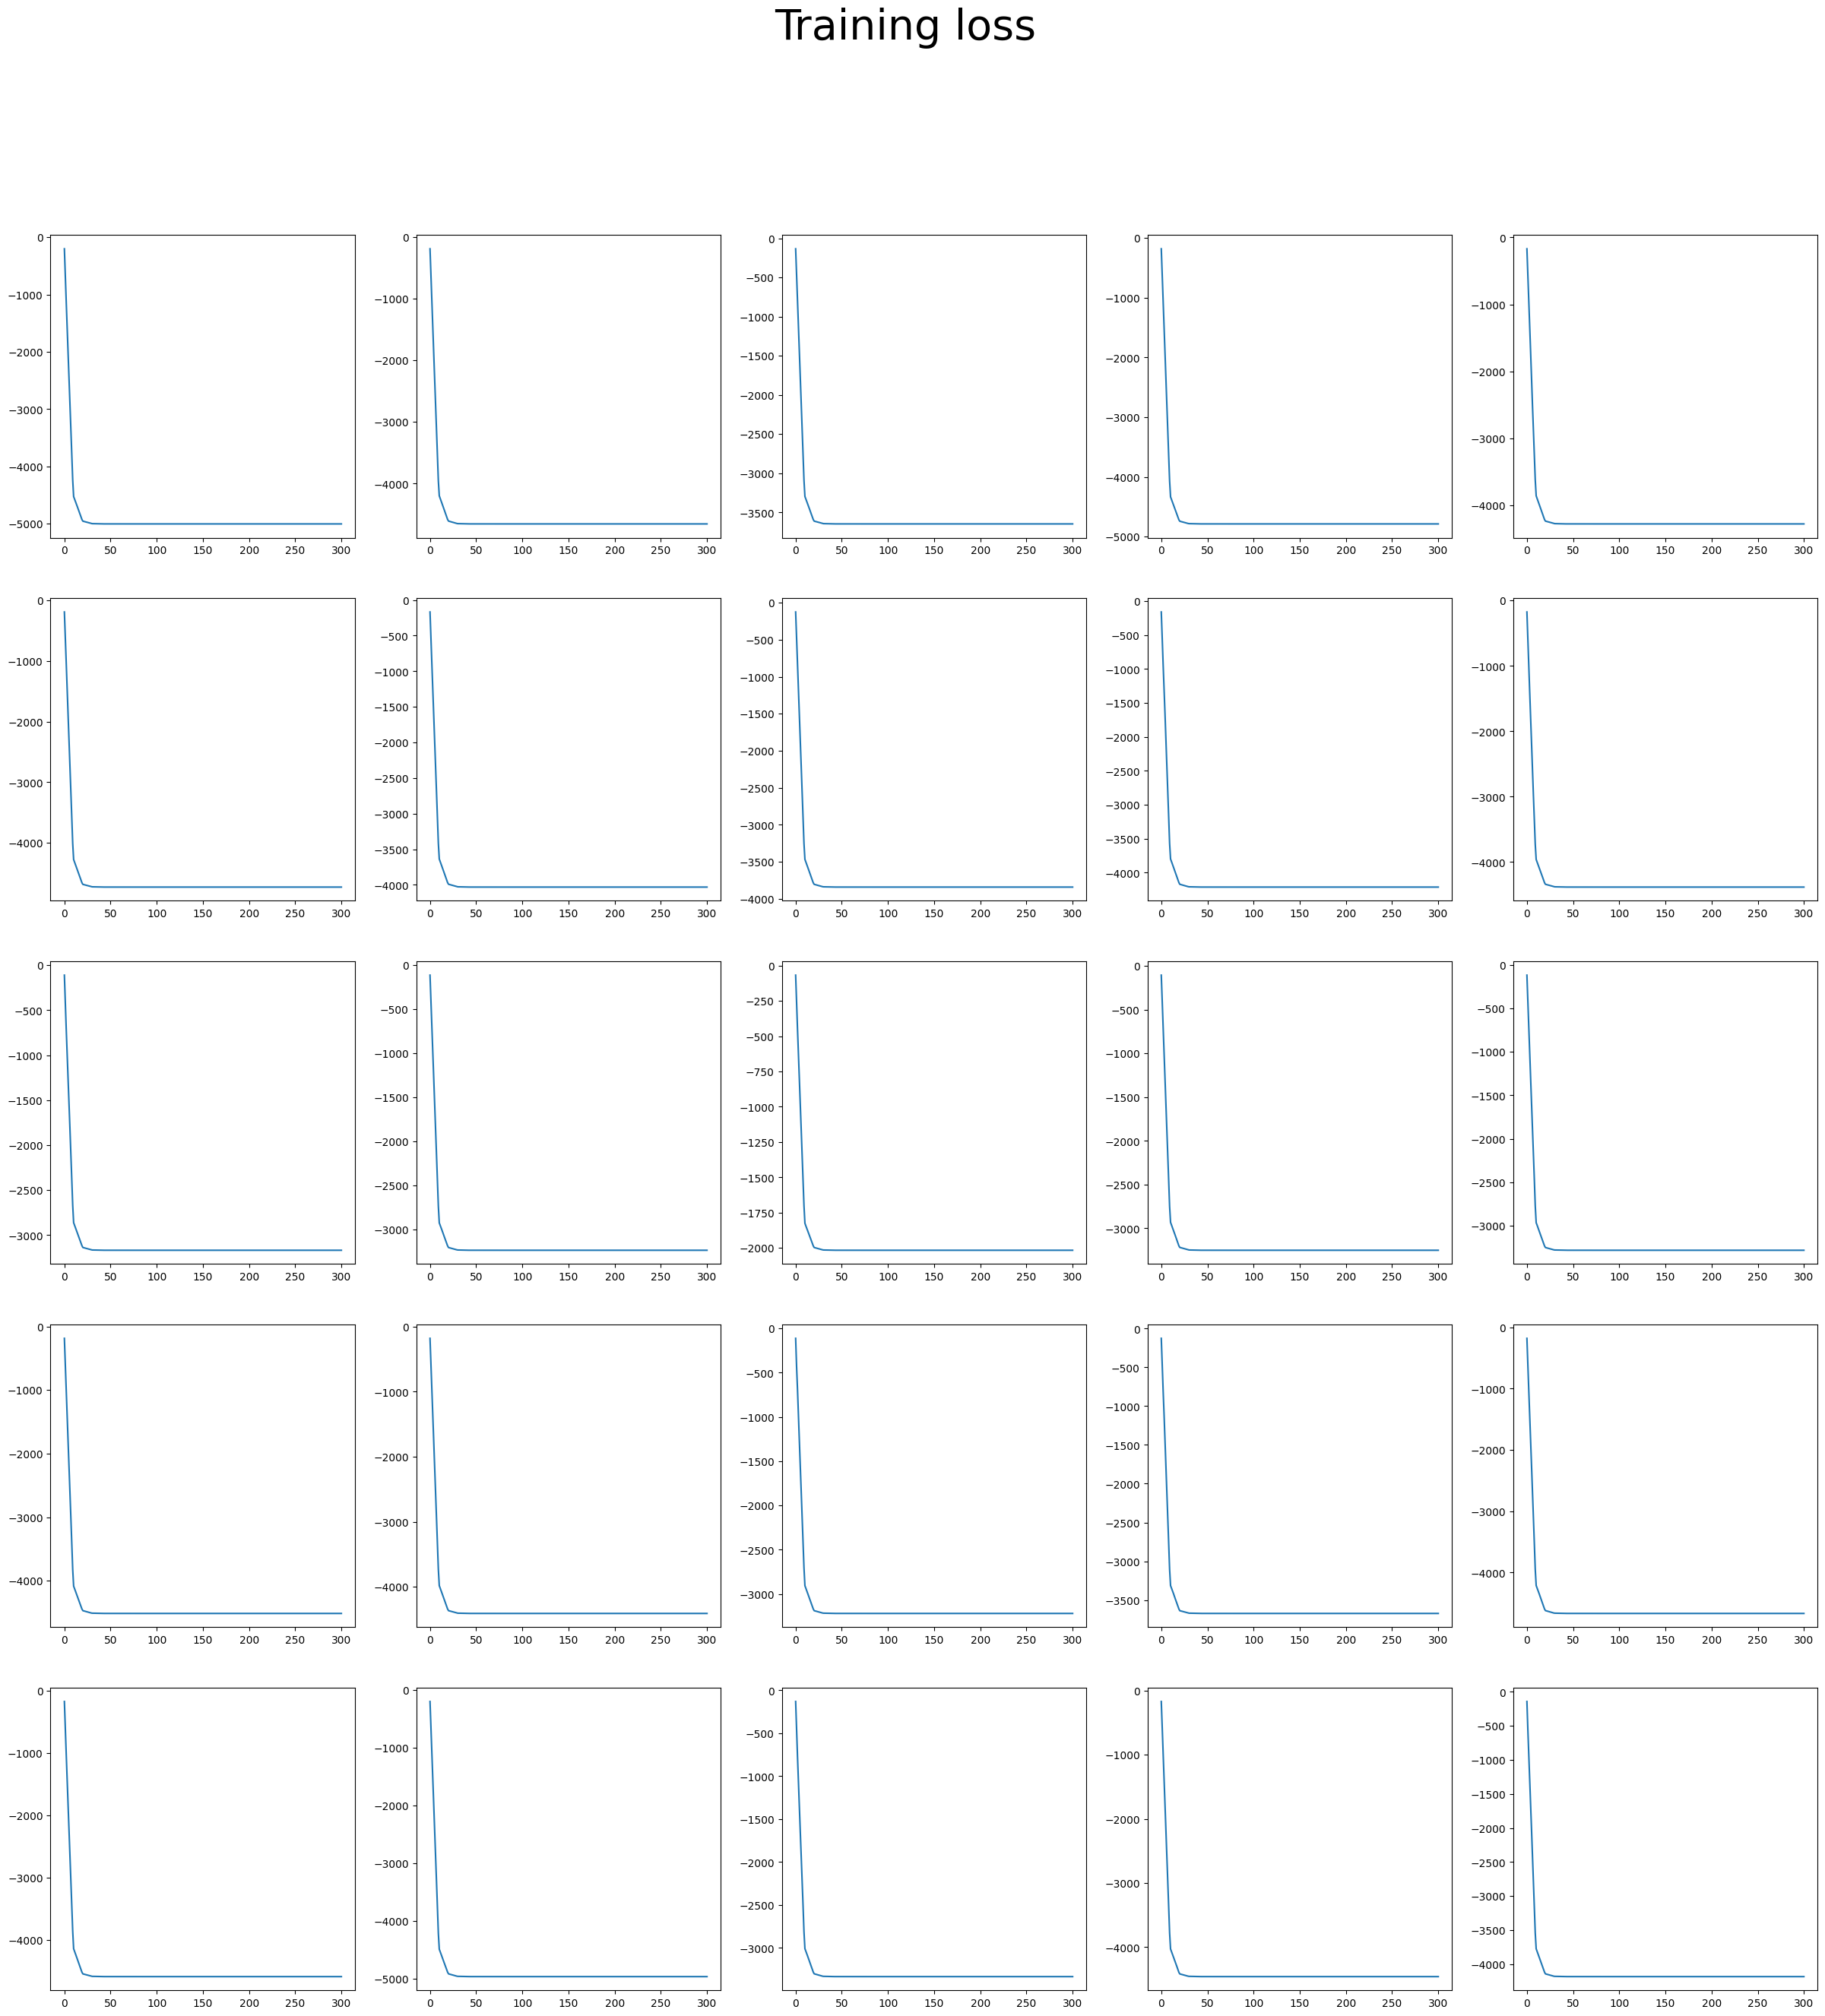

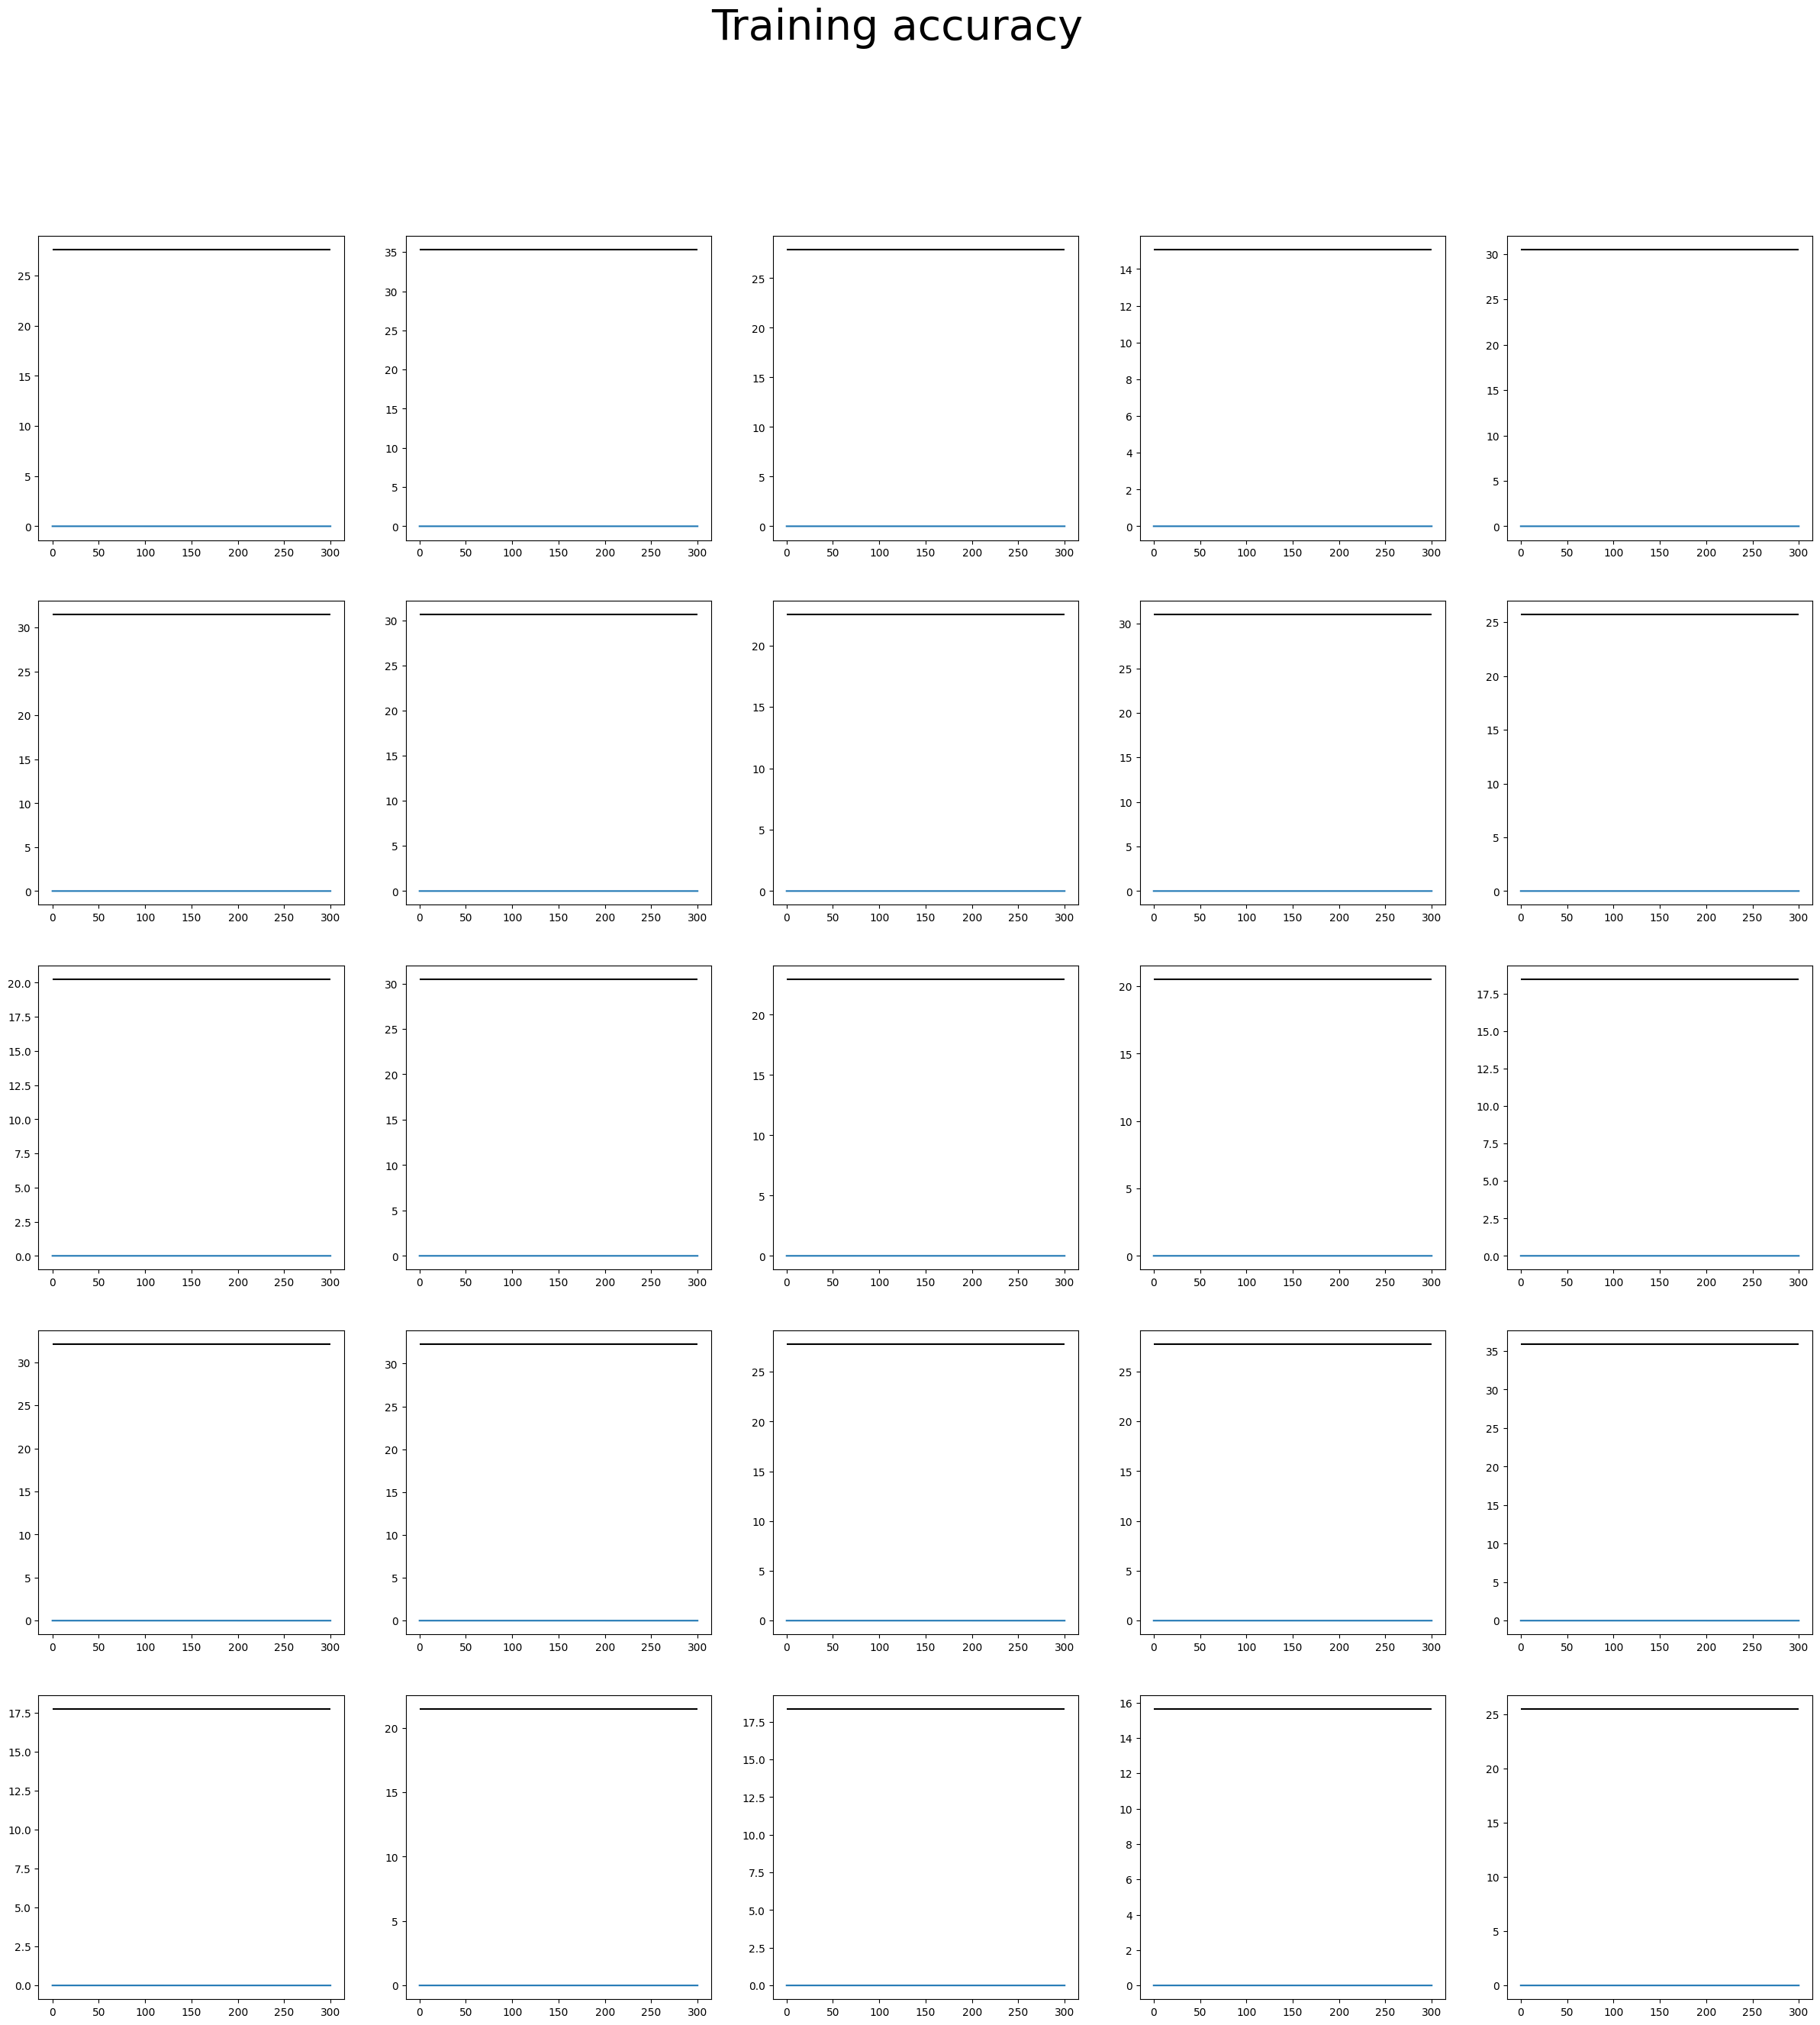

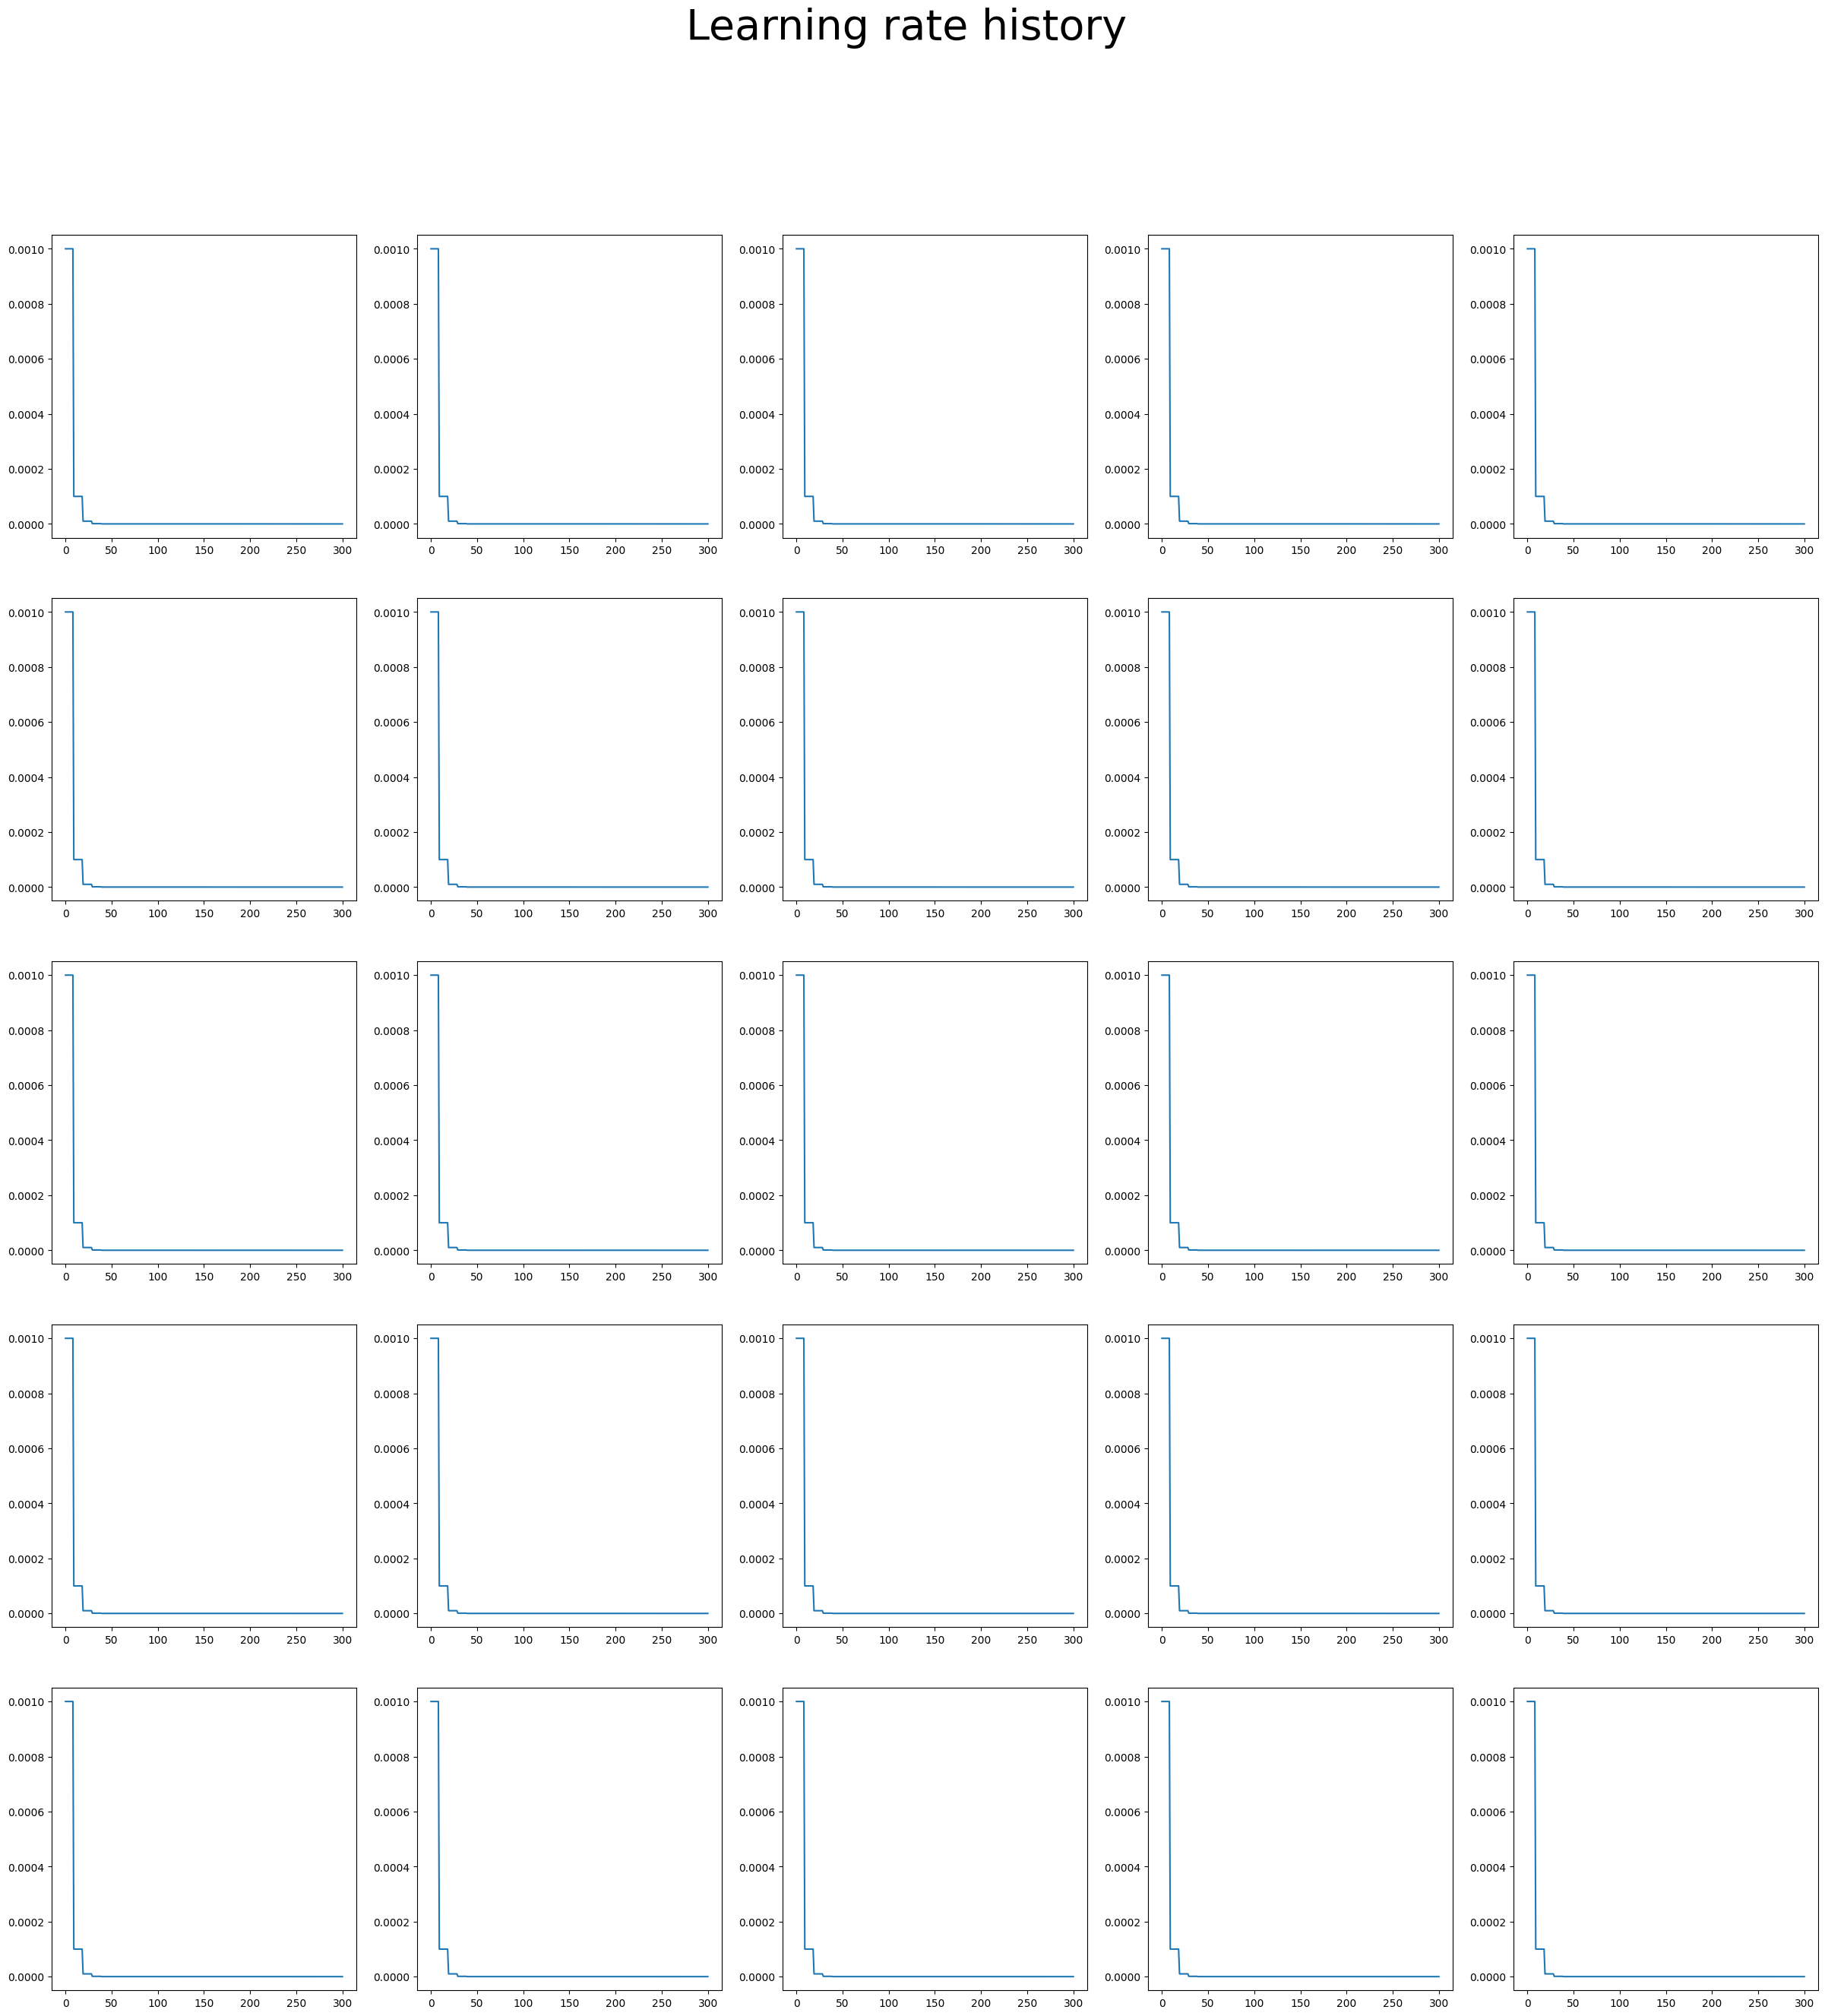

In [13]:
#plot the Trainning
plot_training(Training, num_epochs, outpath)

## Testing

/content/drive/MyDrive/Project2/SVM/SVM.py:462: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(2*3,3))


saving pattern into trials/testing_patterns_example


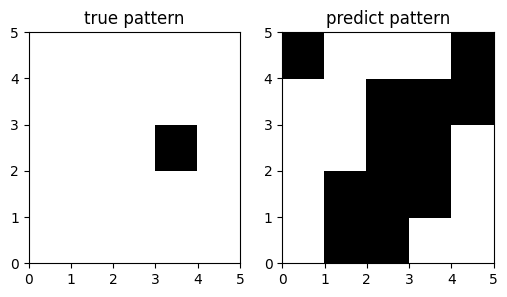

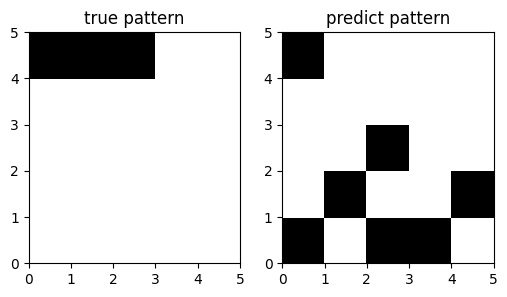

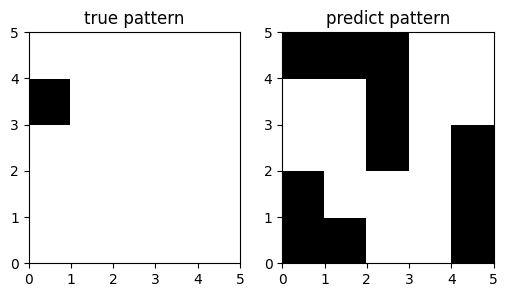

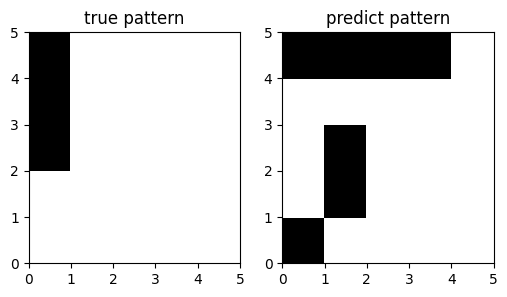

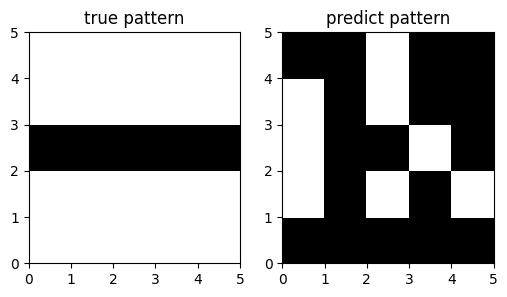

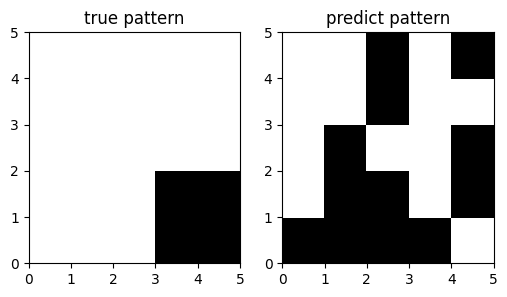

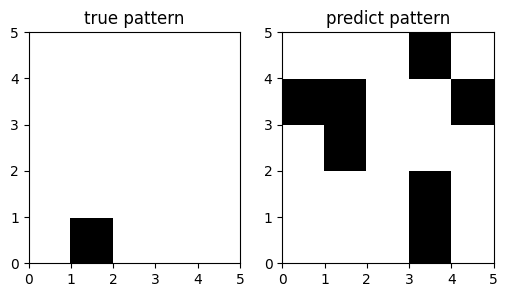

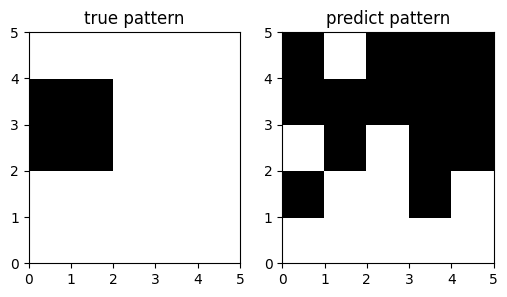

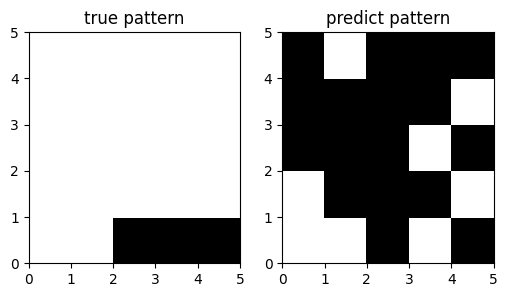

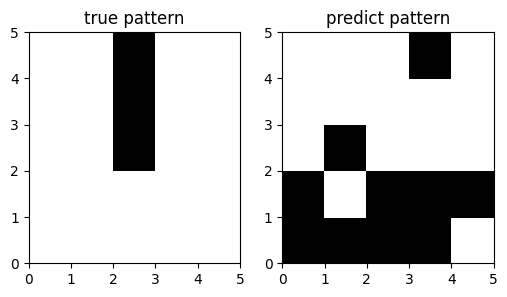

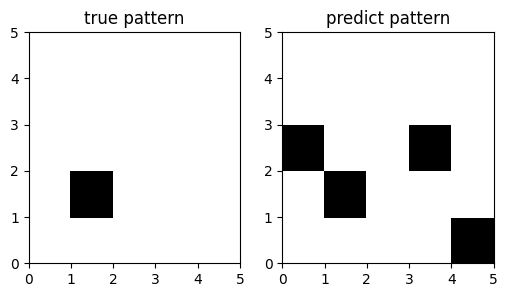

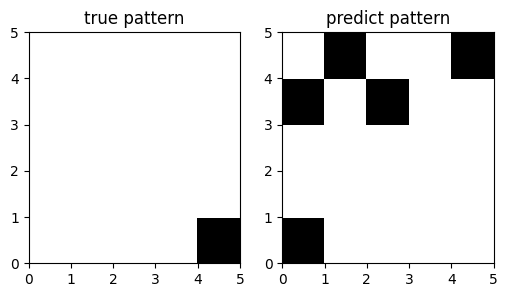

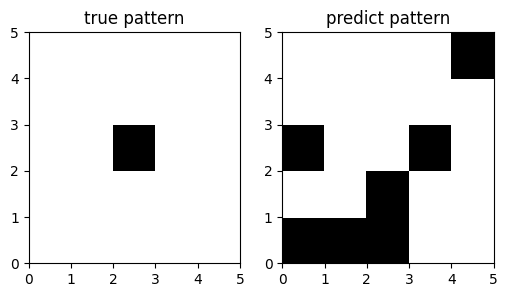

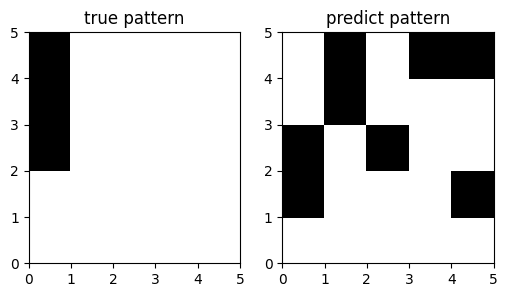

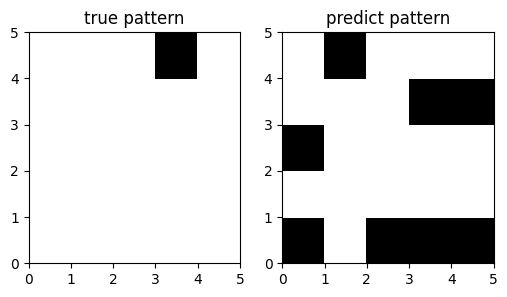

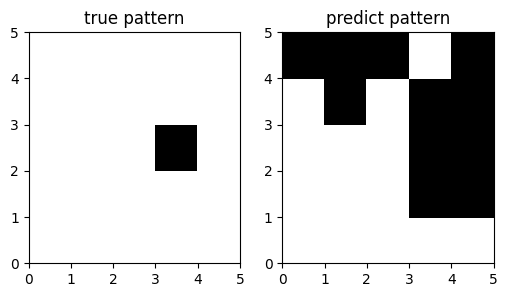

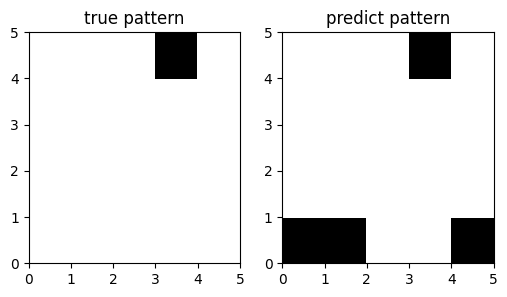

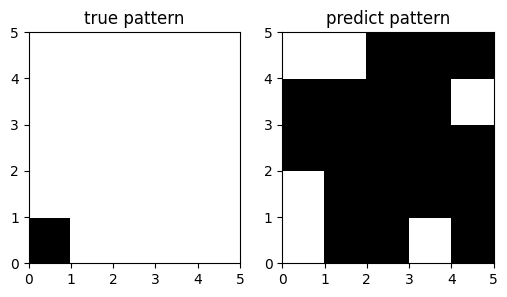

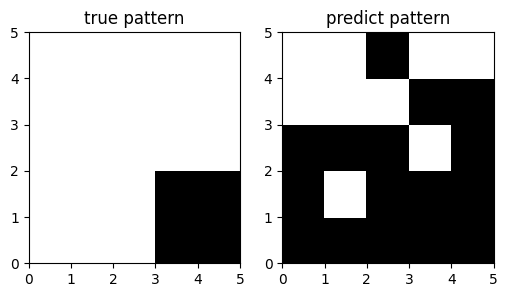

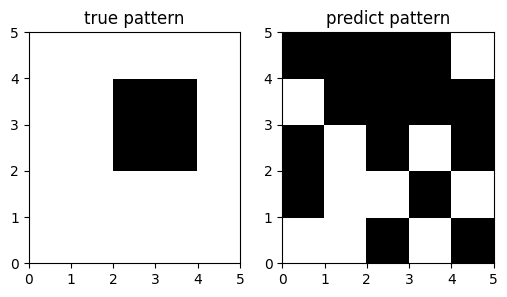

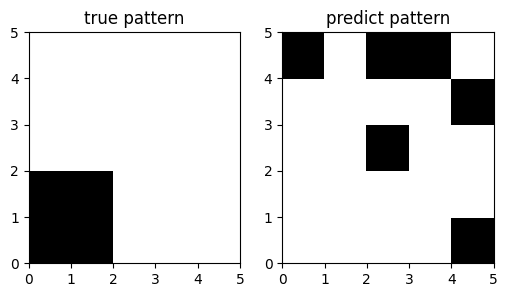

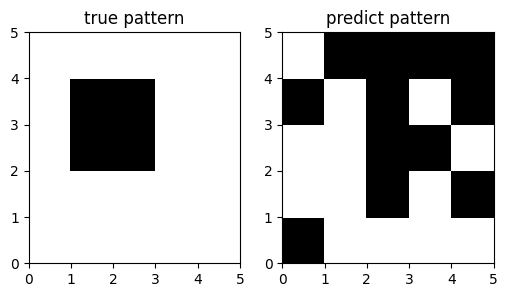

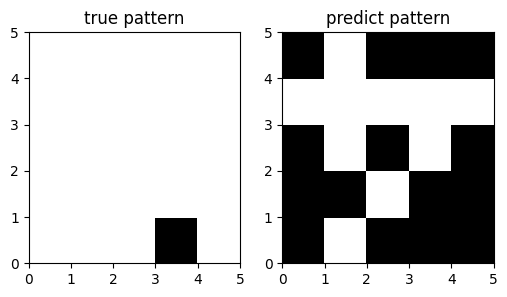

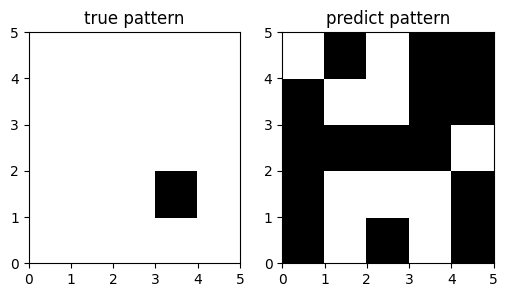

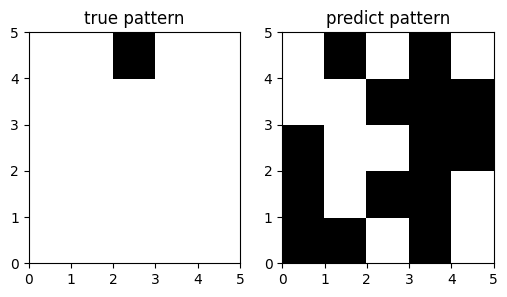

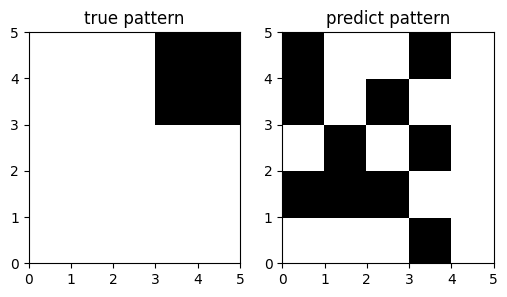

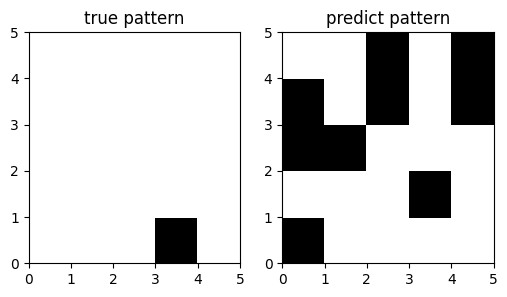

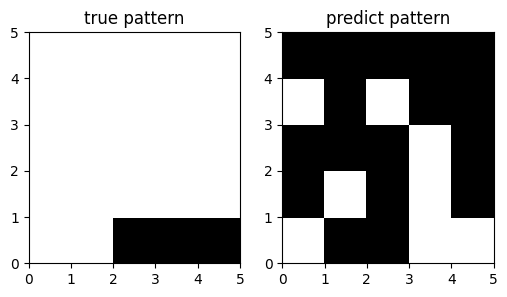

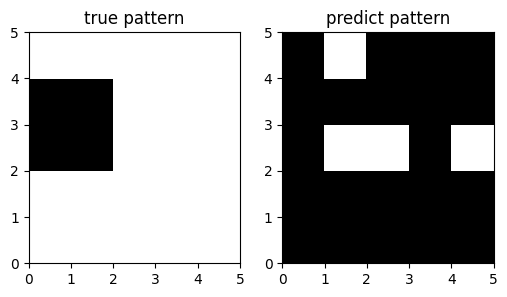

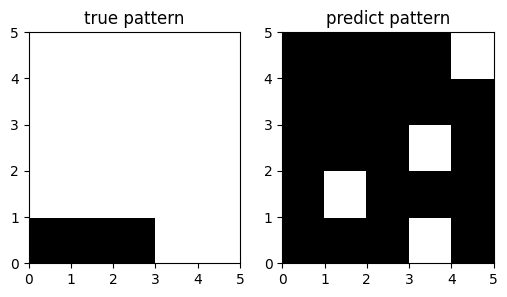

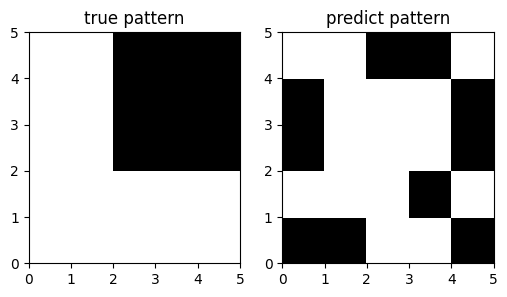

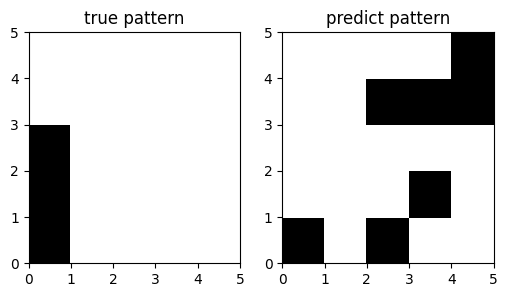

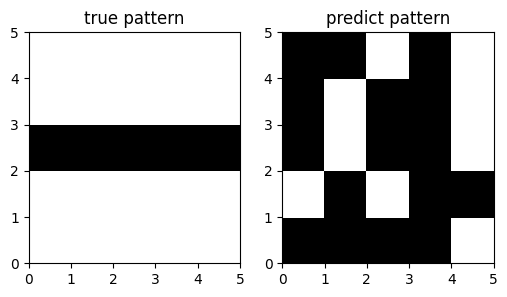

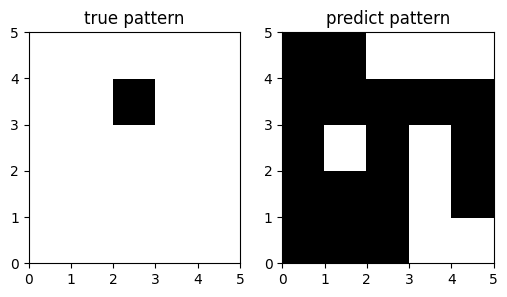

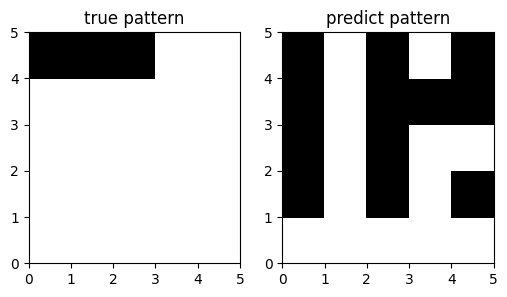

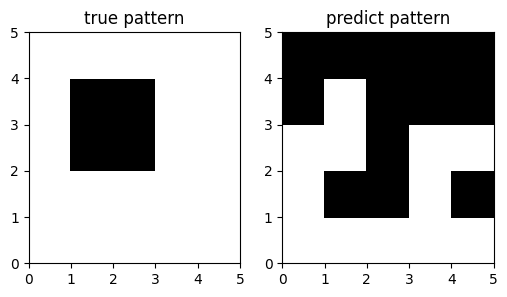

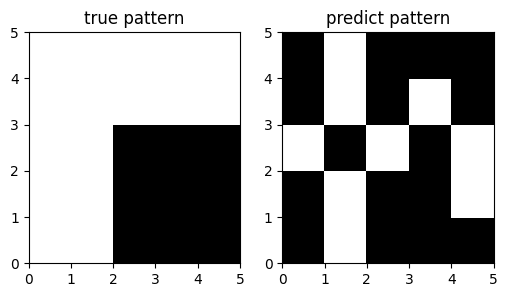

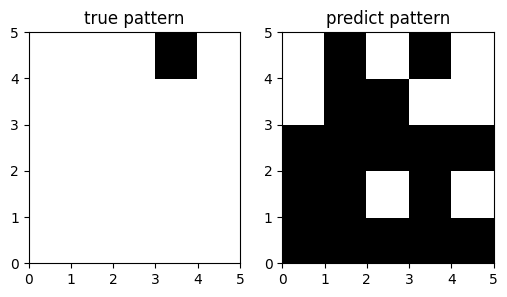

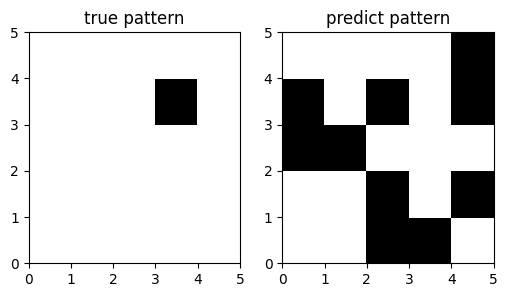

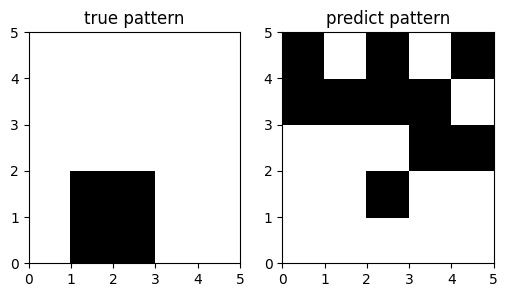

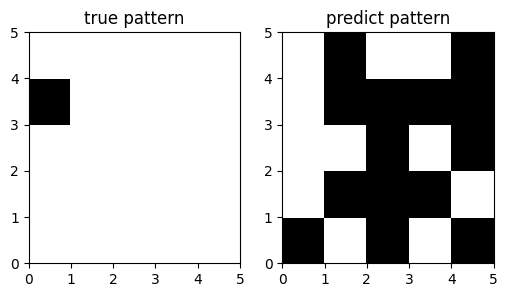

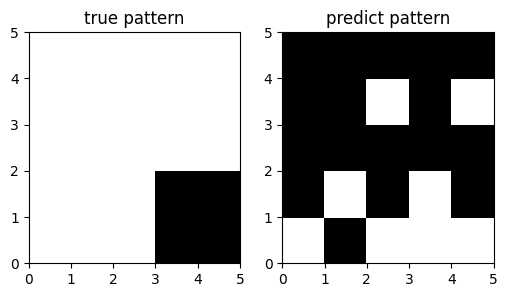

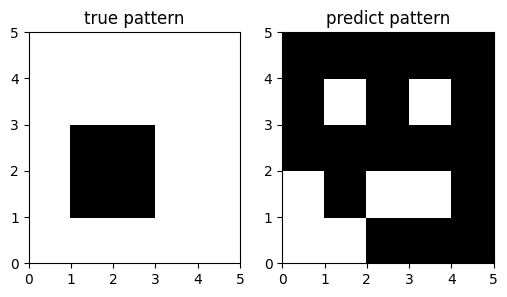

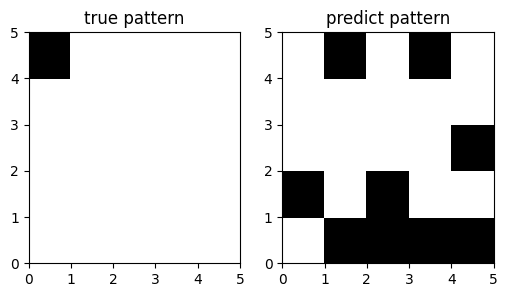

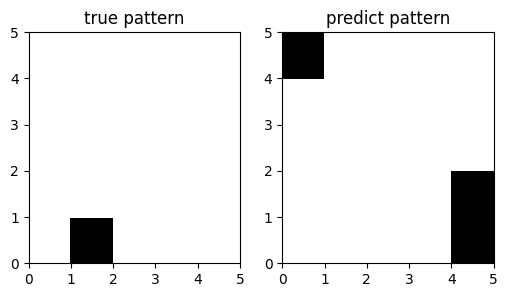

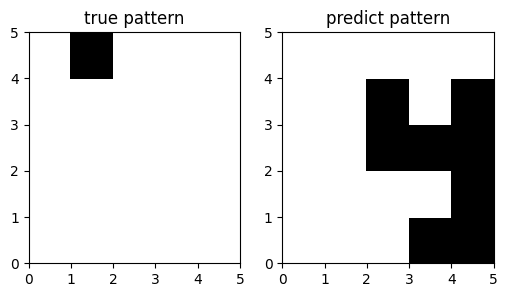

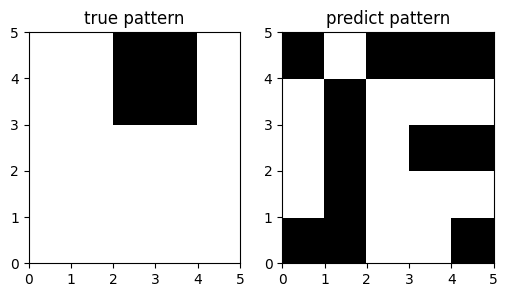

In [14]:
Testing = test(model, test_loader, outpath)

#### Results of the Testing

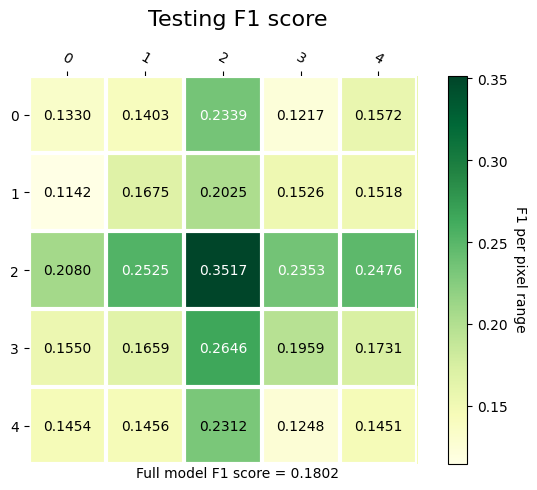

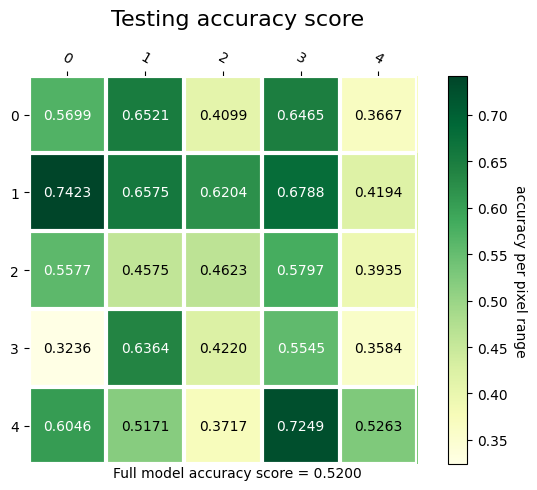

saving done in /trials/plots directory


In [15]:
plot_testing(Testing, outpath)

## Save into csv files

In [19]:
param = {'num_epochs': num_epochs,
           'batch_size': batch_size,
           'Optimizer param lr': lr,
           'Optimizer param batas' : betas,
           'Optimizer param eps' : eps,
           'Optimizer param weight decay' : weight_decay,
           'scheduler param step size' : step_size,
           'scheduler param gamma': gamma}

In [20]:
save_trial(Training, Testing, param, outpath)

trials saved in /trials directory


### ================= TO PUT IN THE .py FILE =================

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

In [ ]:
# ===== Parameters =====
#for the SVM pixel
num_epochs = 300
batch_size = 50

#optimizer: Adam
lr=0.001
betas=(0.9, 0.999)
eps=1e-08
weight_decay=0

#scheduler
step_size = 10
gamma = 0.1

param = {'num_epochs': num_epochs,
           'batch_size_trainning': batch_size_trainning,
           'Optimizer param lr': lr,
           'Optimizer param batas' : betas,
           'Optimizer param eps' : eps,
           'Optimizer param weight decay' : weight_decay,
           'scheduler param step size' : step_size,
           'scheduler param gamma': gamma}


In [ ]:
#class : SVM_pixel and SVM
class SVM_pixel(torch.nn.Module) :
  """
  SVM_pixel class, support vector machine model classify single pixel
  into the class -1 or 1.
  """
  def __init__(self,  input_size, num_classes=2):
    super(SVM_pixel, self).__init__()
    self.fc = torch.nn.Linear(input_size, num_classes)

    #for the regularisation
    self.reg_type = 'L1' #or 'L2' ?
    self.reg_term = 0.01

    #to have an data type Float32 as an entry
    self.double()

  def forward(self, x):
    out = self.fc(x)
    return out

  def predict_label(self, outputs):
    _, preds = torch.max(outputs, 1)
    mask = [preds==0]
    preds[mask]= -1
    return preds

In [ ]:
class SVM(torch.nn.Module):
  """
  SVM, support machine model for 5x5 image classification.
  """
  def __init__(self,  input_size, num_classes = 60, pixel_nb = 25):
    super(SVM, self).__init__()
    self.models = []

    for i in range(pixel_nb) :
      model = SVM_pixel(input_size) #inputsize = 192*128 = nb of feature

      self.models.append(model)

  def forward(self, x):
    for i,model in enumerate(self.models):
      out = model(x)
      if 'outs' in locals() :
        outs=torch.concatenate((outs,out), axis = 1)
      else : outs = out

    return outs

  def predict_pattern(self, outputs):
    for i in range(len(self.models)): #shape outputs = [50, 25, 2]) batch_size, num_pixel, nb_class
      pred = self.models[i].predict_label(outputs[:,i,:])  #take only the right pixel

      if i ==0 : preds = pred
      else : preds = torch.concatenate((preds, pred), axis = 0)

    return preds.reshape([outputs.shape[0], outputs.shape[1]]) #size batch_size, nb of pixel

In [ ]:
#train functions train_single_model and train
def train_single_model(model,
                       train_loader,
                       num_pixel):

    #crit, optim and scheduler
    criterion =  torch.nn.MultiLabelSoftMarginLoss() #torch.nn.SoftMarginLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
    scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    #regularization parameters
    reg_type = model.reg_type
    reg_term = model.reg_term

    loss_per_epoch = []
    acc_per_epoch = []
    lr_history = []

    for epoch in range(num_epochs):
      running_corrects = 0.0
      running_loss = 0.0

      model.train()  # Set model to training model

      for batch_x, batch_y in train_loader:
        batch_x, batch_y = resize_batch(batch_x, batch_y,  num_pixel)

        #running on gpu
        #batch_x = batch_x.to(device)
        #batch_y = batch_y.to(device)

        outputs = model(batch_x)

        preds = model.predict_label(outputs)
        loss = criterion(outputs, batch_y)

        # Add regularization:  Full loss = data loss + regularization loss
        weight = model.fc.weight.squeeze()

        if model.reg_type == 'L1':  # add L1 (LASSO - Least Absolute Shrinkage and Selection Operator)
                                                        # loss which leads to sparsity.
            loss += model.reg_term * torch.sum(torch.abs(weight))

        elif model.reg_type == 'L2':   # add L2 (Ridge) loss
            loss += model.reg_term * torch.sum(weight * weight)

        #backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_x.size(0)
        running_corrects += torch.sum(preds == batch_y.data)

      scheduler.step()

      #save the loss, accuracy and lr
      loss_per_epoch.append(running_loss / len(train_loader.dataset))
      acc_per_epoch.append(running_corrects / len(train_loader.dataset))
      lr_history.append(scheduler.get_last_lr()[0])

      if epoch%100 ==0 : #plot info only every 100 epochs
        print(f'Epoch: {epoch}', 'Loss: {:.4f}'.format(running_loss / len(train_loader.dataset)), 'Acc: {:.4f}'.format(running_corrects/ len(train_loader.dataset)))

    return loss_per_epoch, acc_per_epoch, lr_history

In [ ]:
def eval_single_model(model,
                       val_loader,
                       num_pixel):


  criterion = torch.nn.SoftMarginLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
  scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  #regularization parameters
  reg_type = model.reg_type
  reg_term = model.reg_term

  loss_per_epoch = []
  acc_per_epoch = []

  #init
  best_acc = 0
  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs):
    running_corrects = 0.0
    running_loss = 0.0

    model.eval()  # Set model to validating mode

    for batch_x, batch_y in val_loader:
      batch_x, batch_y = resize_batch(batch_x, batch_y,  num_pixel)

      #running on gpu
      #batch_x = batch_x.to(device)
      #batch_y = batch_y.to(device)

      outputs = model(batch_x)
      preds = model.predict_label(outputs)
      loss = criterion(outputs, batch_y)

      # Add regularization:  Full loss = data loss + regularization loss
      weight = model.fc.weight.squeeze()

      if model.reg_type == 'L1':  # add L1 (LASSO) (which leads to sparsity)
        loss += model.reg_term * torch.sum(torch.abs(weight))

      elif model.reg_type == 'L2':   # add L2 (Ridge)
          loss += model.reg_term * torch.sum(weight * weight)

      # Collect statistics
      running_loss += loss.item() * batch_x.size(0)  # images.size(0) is batch size.
      running_corrects += torch.sum(preds == batch_y.data)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects/ len(val_loader.dataset)

    if epoch_acc > best_acc: #we keep the model if it has better acc
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())

  print('Best val Acc in percentage: {:.4f}'.format(best_acc))

  # Load best model weights
  model.load_state_dict(best_model_wts)

  return best_acc

In [ ]:
def train(full_model,
          train_loader,eval_loader
          ) :

  to_store = pd.DataFrame(columns=['Pixel n°', 'Trainning loss','Learning rate history', 'Trainning accuracy', 'Validating accuracy'])

  for i, model in enumerate(full_model.models):
    print('Pixel ', i )
    loss_per_epoch, acc_per_epoch, lr_history = train_single_model(model,train_loader, i)

    best_acc = eval_single_model(model, val_loader, i)

    df = pd.DataFrame([[i, loss_per_epoch, acc_per_epoch,lr_history, best_acc]])

    #Store
    to_store.loc[len(to_store.index)] =  [i, loss_per_epoch,lr_history,acc_per_epoch, best_acc]

  return to_store

In [ ]:
#test functions
def test_single_model(model, test_loader, num_pixel) :
  ''' give the prediction of a single pixel'''

  with torch.no_grad():
    for batch_x, batch_y in test_loader:

        batch_x, batch_y = resize_batch(batch_x, batch_y, num_pixel)

        #running on gpu
        #batch_x = batch_x.to(device)
        #batch_y = batch_y.to(device)

        outputs = model(batch_x)

        pred = model.predict_label(outputs)

        if 'Y' in locals():
          Y= torch.concatenate((Y, batch_y))
        else : Y = batch_y

        if 'preds' in locals() :
          preds = torch.concatenate((preds,pred))
        else : preds = pred

    f1, acc = F1andscore(Y, preds)
  return f1, acc


def test(trained_model, test_loader, outpath) :

  to_store = pd.DataFrame(columns=['Testing singles F1', 'Testing singles accuracy', 'Testing full F1', 'Testing full acc'])

  #test 1 : the single test over each pixel
  f1_single = []
  acc_single = []

  for i, model in enumerate(trained_model.models) :
    f1, acc = test_single_model(model, test_loader, i)
    f1_single.append(f1)
    acc_single.append(acc)

  to_store['Testing singles F1'] = f1_single
  to_store['Testing singles accuracy'] = acc_single

  with torch.no_grad():
    for batch_x, batch_y in test_loader: #size = 1
        batch_x = batch_x.flatten(2)
        batch_y = batch_y.flatten(1)

        #running on gpu
        #batch_x = batch_x.to(device)
        #batch_y = batch_y.to(device)

        outputs = trained_model(batch_x)

        pred_pattern = trained_model.predict_pattern(outputs)

        F1, accuracy = F1andscore(batch_y, pred_pattern)

  save_prediction(batch_y, pred_pattern, outpath) #save only the last batch as an example

  to_store['Testing full F1'] = F1
  to_store['Testing full acc'] = accuracy

  return to_store

In [ ]:
#resize function for the batches -> to incorporate to the data processing
def F1andscore(true, pred):
  TP = torch.sum((true == 1) & (pred == 1)) #true positive: if pred =1 both
  FP = torch.sum((true == -1) & (pred == 1)) #false positive: if pred = 1 and pat = -1
  FN = torch.sum((true == 1) & (pred == -1)) #False negative : if -1 in both
  TN = torch.sum((true == -1) & (pred == -1))

  # Calculate precision and recall
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)

  return 2 * (precision * recall) / (precision + recall), (TP + TN)/(TP+TN+FP+FN)

def resize_batch(batch_x, batch_y, num_pixel):
  #reshape x_batch
  batch_x= batch_x.flatten(2)
  shape0 = batch_x.shape[0]
  shape1 = batch_x.shape[2]
  batch_x = batch_x.reshape([shape0, shape1])

  #take the right batch for the right pixel
  batch_y = batch_y.flatten(1)

  #take the right pixel
  batch_y = batch_y[:,num_pixel]
  batch_y = batch_y.reshape(batch_y.shape[0], 1)

  return batch_x, batch_y


#saving functions
def save_trial(df_trainning, df_testing, param, outpath):

  #add the parameters column
  df_param = pd.DataFrame.from_dict(param, orient='index')

  path = outpath

  import os
  os.makedirs(path, exist_ok=True)

  df_param.to_csv(path + '/parameters.csv')
  df_testing.to_csv(path + '/testing.csv')
  df_trainning.to_csv(path + '/training.csv')

  print('trials saved in Project2/trials')

#plotting function
def plot_training(Training_results, num_epochs, outpath) :
  #columns=['Pixel n°', 'Trainning loss', 'Trainning accuracy','Learning rate history', 'Validating accuracy']

  #plot the 25 trainning loss and accuracy over the epochs in a subplot + one point for the best accuracy
  fig1, axs1 = plt.subplots(5, 5, figsize=(30,30))
  fig1.suptitle('Training loss', fontsize=40)
  fig2, axs2 = plt.subplots(5, 5, figsize=(30,30))
  fig2.suptitle('Training accuracy', fontsize=40)
  fig3, axs3 = plt.subplots(5, 5, figsize=(30,30))
  fig3.suptitle('Learning rate history', fontsize=40)

  #x axis are the nb of epochs
  x = np.linspace(0,  num_epochs, num_epochs)

  for i, pixel in Training_results.iterrows() :
    n = i%5
    if i < 5:
      m = 0
    if i >= 5 and i < 10:
      m = 1
    if i >=10 and i < 15:
      m=2
    if i >= 15 and i < 20 :
      m = 3
    if i >=20 and i < 25:
      m = 4

    #'Trainning_loss'
    axs1[n,m].plot(x, pixel[1])

    # 'Trainning_accuracy'
    axs2[n,m].plot(x, pixel[3])
    axs2[n,m].hlines(pixel[4],0,num_epochs ,color='k',  label='validation accuracy')


    #'Learning rate history'
    axs3[n,m].plot(x, pixel[2])

    #save plot into trials directory (same as the csv files)
    outpath = outpath
    import os
    os.makedirs(outpath, exist_ok=True)

    fig1.savefig(os.path.join(outpath,"Training_loss.png"))
    fig2.savefig(os.path.join(outpath,"Training_accuracy.png"))
    fig3.savefig(os.path.join(outpath, "Learning_rate_history"))

  print('saving done in Project2/trials/plots')

def plot_testing(Testing_results):
  #columns=['Testing singles F1', 'Testing singles accuracy', 'Testing full F1', 'Testing full acc']

  #heat map 5x5 for Testing singles F1

  F1_score = Testing_results['Testing singles F1'].to_numpy(dtype = np.float64).reshape((5,5))
  Acc = Testing_results['Testing singles accuracy'].to_numpy(dtype = np.float64).reshape((5,5))

  fig1, ax1 = plt.subplots()

  im, cbar = heatmap(F1_score, ['0', '1', '2', '3', '4'], ['0', '1', '2', '3', '4'], ax=ax1,
                   cmap="YlGn", cbarlabel="F1 per pixel range ")

  texts = annotate_heatmap(im, valfmt="{x:.4f}")

  fig1.suptitle('Testing F1 score', fontsize=16)

  #+print(above as a label the Testing full F1)

  full_f1 = Testing_results['Testing full F1'][1]

  fig1.text(.5, .005, 'Full model F1 score = {:.4f}'.format(full_f1), ha='center')

  fig1.tight_layout()


  fig2, ax2 = plt.subplots()

  im, cbar = heatmap(Acc, ['0', '1', '2', '3', '4'], ['0', '1', '2', '3', '4'], ax=ax2,
                   cmap="YlGn", cbarlabel="accuracy per pixel range")

  texts = annotate_heatmap(im, valfmt="{x:.4f}")

  fig2.suptitle('Testing accuracy score', fontsize=16)

  full_acc = Testing_results['Testing full acc'][1]

  fig2.text(.5, .005, 'Full model accuracy score = {:.4f}'.format(full_acc), ha='center')

  fig2.tight_layout()

  #save plot into trials directory (same as the csv files)
  outpath = 'drive/MyDrive/Project2/trials/plots'

  import os
  os.makedirs(outpath, exist_ok=True)

  fig1.savefig(os.path.join(outpath,"Testing_f1.png"))
  fig2.savefig(os.path.join(outpath,"Testing_accuracy.png"))

  print('saving done in Project2/trials/plots')

def save_prediction(true_patterns, pred_patterns, outpath) :
  #import matplotlib.backends.backend_pdf
  import os

  outpath = outpath + '/testing_pattern_example'
  os.makedirs(outpath, exist_ok=True)
  #pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(outpath,"testing_pattern.pdf"))
  i = 0
  for true_pattern, pred_pattern in zip(true_patterns, pred_patterns) :
    fig, ax = plot_pattern([true_pattern, pred_pattern])
    i+= 1
    filname = f'Pred_vs_true_n°{i}.png'
    fig.savefig(os.path.join(outpath, filname))

  print('saving pattern into trials/testing_patterns_example')

def plot_pattern(patterns) :
  from matplotlib.colors import LogNorm
  fig, ax = plt.subplots(1, 2, figsize=(2*3,3))

  for i, pattern in enumerate(patterns) :
    Z = pattern.numpy().reshape([5,5])
    c = ax[i].pcolor(Z, cmap='binary')

  ax[0].set_title('true pattern')
  ax[1].set_title('predict pattern')

  #fig.text(.5, .005, 'F1 score for this pattern = {:.4f}'.format(f1), ha='center')

  return fig, ax

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    from matplotlib.ticker import StrMethodFormatter
    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts